In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

In [2]:
tsx = yf.download("^GSPTSE", start="2010-01-01", end="2023-01-01")
tsx.sort_values(by=['Date'], inplace=True, ascending=False)
tsx.reset_index(inplace=True)

START_DATE = "2010/01/01"
END_DATE = "2023/01/01"

file_path_cpi_inflation = "src/CPI_and_inflation.csv"
cpi_inflation = pd.read_csv(file_path_cpi_inflation)

file_path_gdp = "src/GDP_growthRate.csv"
gdp = pd.read_csv(file_path_gdp)

file_path_unemployment = "src/Unemployment rates.csv"
unemployment = pd.read_csv(file_path_unemployment)

[*********************100%***********************]  1 of 1 completed
C:\Users\User\AppData\Local\Temp\ipykernel_6640\2458744912.py:12: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  gdp = pd.read_csv(file_path_gdp)


In [3]:
tsx['Date'] = pd.to_datetime(tsx['Date']).dt.strftime('%Y/%m/%d')

cpi_inflation['Date'] = pd.to_datetime(cpi_inflation['REF_DATE'], format='%Y-%m').dt.strftime('%Y/%m/01')

gdp['Date'] = pd.to_datetime(gdp['REF_DATE'], format='%Y-%m').dt.strftime('%Y/%m/01')

unemployment['Date'] = pd.to_datetime(unemployment['REF_DATE'].astype(str) + '-01-01', format='%Y-%m-%d').dt.strftime('%Y/%m/%d')

In [4]:
cpi_filtered_data = cpi_inflation[(cpi_inflation['Date'] >= START_DATE) & (cpi_inflation['Date'] <= END_DATE)]
gdp_filtered_data = gdp[(gdp['Date'] >= START_DATE) & (gdp['Date'] <= END_DATE)]
unemployment_filtered_data = unemployment[(unemployment['Date'] >= START_DATE) & (unemployment['Date'] <= END_DATE)]

In [5]:
print(f"{cpi_filtered_data.columns} '\n', {gdp_filtered_data.columns}'\n', {unemployment_filtered_data.columns}'\n'")

Index(['REF_DATE', 'GEO', 'DGUID', 'Alternative measures', 'UOM', 'UOM_ID',
       'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'VALUE', 'STATUS',
       'SYMBOL', 'TERMINATED', 'DECIMALS', 'Date'],
      dtype='object') '
', Index(['REF_DATE', 'GEO', 'DGUID', 'Seasonal adjustment', 'Prices',
       'North American Industry Classification System (NAICS)', 'UOM',
       'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'VALUE',
       'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS', 'Date'],
      dtype='object')'
', Index(['REF_DATE', 'GEO', 'DGUID',
       'Characteristics of the population aged 15 and over',
       'Educational attainment', 'UOM', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID',
       'VECTOR', 'COORDINATE', 'VALUE', 'STATUS', 'SYMBOL', 'TERMINATED',
       'DECIMALS', 'Date'],
      dtype='object')'
'


In [6]:
cpi_filtered_data = cpi_inflation[(cpi_inflation['Date'] >= START_DATE) & (cpi_inflation['Date'] <= END_DATE)]
gdp_filtered_data = gdp[(gdp['Date'] >= START_DATE) & (gdp['Date'] <= END_DATE)]
unemployment_filtered_data = unemployment[(unemployment['Date'] >= START_DATE) & (unemployment['Date'] <= END_DATE)]

In [7]:
print(cpi_filtered_data['Alternative measures'].unique())

['Measure of core inflation based on a factor model, CPI-common (year-over-year percent change)'
 'Measure of core inflation based on a weighted median approach, CPI-median (year-over-year percent change)'
 'Measure of core inflation based on a trimmed mean approach, CPI-trim (year-over-year percent change)'
 'Measure of core inflation based on a weighted median approach, CPI-median (index, 198901=100)'
 'Measure of core inflation based on a trimmed mean approach, CPI-trim (index, 198901=100)'
 'Consumer Price Index (CPI), all-items excluding eight of the most volatile components as defined by the Bank of Canada and excluding the effect of changes in indirect taxes'
 'Consumer Price Index (CPI), all-items excluding eight of the most volatile components as defined by the Bank of Canada'
 'Consumer Price Index (CPI), all-items excluding the effect of indirect taxes'
 'Consumer Price Index (CPI), all-items excluding eight of the most volatile components as defined by the Bank of Canada an

In [8]:
cpi_filtered_data = cpi_filtered_data[['Date', 'Alternative measures', 'VALUE']]
condition = (
    cpi_filtered_data['Alternative measures'] ==
    "Consumer Price Index (CPI), all-items excluding eight of the most volatile components as defined by the Bank of Canada and excluding the effect of changes in indirect taxes"
)
cpi_filtered_data = cpi_filtered_data[condition]

cpi_filtered_data.pop('Alternative measures')
cpi_filtered_data.rename(columns={'VALUE': 'CPI value'}, inplace=True)

In [9]:
print(gdp_filtered_data['North American Industry Classification System (NAICS)'].unique())

['All industries [T001]' 'Goods-producing industries [T002]'
 'Service-producing industries [T003]' 'Business sector industries [T004]'
 'Business sector, goods [T005]' 'Business sector, services [T006]'
 'Non-business sector industries [T007]'
 'Non-business sector, goods [T008]'
 'Non-business sector, services [T009]' 'Industrial production [T010]'
 'Non-durable manufacturing industries [T011]'
 'Durable manufacturing industries [T012]'
 'Information and communication technology sector [T013]'
 'Information and communication technology, manufacturing [T014]'
 'Information and communication technology, services [T015]'
 'Energy sector [T016]' 'Industrial production (1950 definition) [T017]'
 'Public Sector [T018]' 'Content and media sector [T019]'
 'All industries (except cannabis sector) [T020]' 'Cannabis sector [T021]'
 'Cannabis sector (licensed) [T022]' 'Cannabis sector (unlicensed) [T023]'
 'All industries (except unlicensed cannabis sector) [T024]'
 'Agriculture, forestry, fishi

In [10]:
gdp_filtered_data = gdp_filtered_data[['Date', 'North American Industry Classification System (NAICS)', 'VALUE']]
condition = (
    gdp_filtered_data['North American Industry Classification System (NAICS)'] == "All industries [T001]"
)
gdp_filtered_data = gdp_filtered_data[condition]
gdp_filtered_data.rename(columns={'VALUE': 'GDP growth rate value'}, inplace=True)
gdp_filtered_data.pop('North American Industry Classification System (NAICS)')

134316    All industries [T001]
134603    All industries [T001]
134890    All industries [T001]
135177    All industries [T001]
135464    All industries [T001]
                  ...          
268058    All industries [T001]
268345    All industries [T001]
268632    All industries [T001]
268919    All industries [T001]
269206    All industries [T001]
Name: North American Industry Classification System (NAICS), Length: 471, dtype: object

In [11]:
print(unemployment_filtered_data['Educational attainment'].unique())
print(unemployment_filtered_data['Characteristics of the population aged 15 and over'].unique())

['All levels of education' 'Less than high school' 'High school'
 'College or trade' 'University']
['Population, Canada' 'Population, off reserve Indigenous']


In [12]:
unemployment_filtered_data = unemployment_filtered_data[['Date',
                                                         'Characteristics of the population aged 15 and over',
                                                         'Educational attainment',
                                                         'VALUE']]

condition = (
    (unemployment_filtered_data['Characteristics of the population aged 15 and over'] == "Population, Canada") &
    (unemployment_filtered_data['Educational attainment'] == "All levels of education")
)

unemployment_filtered_data = unemployment_filtered_data[condition]

unemployment_filtered_data.rename(columns={'VALUE': 'Unemployment rate value'}, inplace=True)

unemployment_filtered_data.pop('Characteristics of the population aged 15 and over')
unemployment_filtered_data.pop('Educational attainment')

200    All levels of education
210    All levels of education
220    All levels of education
230    All levels of education
240    All levels of education
250    All levels of education
260    All levels of education
270    All levels of education
280    All levels of education
290    All levels of education
300    All levels of education
310    All levels of education
320    All levels of education
330    All levels of education
Name: Educational attainment, dtype: object

In [13]:
# Merge datasets
# Expand CPI data to daily, assuming the CPI value is valid for the entire month
expanded_cpi = []
for idx, row in cpi_filtered_data.iterrows():
    start_date = pd.to_datetime(row['Date'])
    end_date = start_date + MonthEnd(0)  # End of the month
    daily_dates = pd.date_range(start=start_date, end=end_date, freq='D')
    for date in daily_dates:
        expanded_cpi.append({'Date': date.strftime('%Y/%m/%d'), 'CPI value': row['CPI value']})

cpi_expanded = pd.DataFrame(expanded_cpi)

# Expand GDP data to daily, assuming the GDP value is valid for the entire month
expanded_gdp = []
for idx, row in gdp_filtered_data.iterrows():
    start_date = pd.to_datetime(row['Date'])
    end_date = start_date + MonthEnd(0)  # End of the month
    daily_dates = pd.date_range(start=start_date, end=end_date, freq='D')
    for date in daily_dates:
        expanded_gdp.append({'Date': date.strftime('%Y/%m/%d'), 'GDP growth rate': row['GDP growth rate value']})

gdp_expanded = pd.DataFrame(expanded_gdp)

# Expand unemployment data to daily, assuming the same unemployment rate for the entire year
unemployment_expanded = []
for idx, row in unemployment_filtered_data.iterrows():
    start_date = pd.to_datetime(row['Date'])
    end_date = start_date + pd.DateOffset(years=1) - pd.DateOffset(days=1)  # End of the year
    daily_dates = pd.date_range(start=start_date, end=end_date, freq='D')
    for date in daily_dates:
        unemployment_expanded.append({'Date': date.strftime('%Y/%m/%d'), 'Unemployment rate': row['Unemployment rate value']})

unemployment_expanded = pd.DataFrame(unemployment_expanded)

In [14]:
tsx.columns = ['_'.join(filter(None, col)) if isinstance(col, tuple) else col for col in tsx.columns]

merged_data = pd.merge(tsx, cpi_expanded, on='Date', how='inner')
merged_data = pd.merge(merged_data, gdp_expanded, on='Date', how='inner')
merged_data = pd.merge(merged_data, unemployment_expanded, on='Date', how='inner')
merged_data.pop('Date')

0       2022/12/30
1       2022/12/30
2       2022/12/30
3       2022/12/29
4       2022/12/29
           ...    
9778    2010/01/05
9779    2010/01/05
9780    2010/01/04
9781    2010/01/04
9782    2010/01/04
Name: Date, Length: 9783, dtype: object

In [15]:
print(merged_data.shape)
merged_data.describe

(9783, 9)


<bound method NDFrame.describe of       Adj Close_^GSPTSE  Close_^GSPTSE  High_^GSPTSE   Low_^GSPTSE  \
0          19384.900391   19384.900391  19496.199219  19332.800781   
1          19384.900391   19384.900391  19496.199219  19332.800781   
2          19384.900391   19384.900391  19496.199219  19332.800781   
3          19485.900391   19485.900391  19515.400391  19308.900391   
4          19485.900391   19485.900391  19515.400391  19308.900391   
...                 ...            ...           ...           ...   
9778       11888.099609   11888.099609  11935.200195  11837.200195   
9779       11888.099609   11888.099609  11935.200195  11837.200195   
9780       11866.900391   11866.900391  11872.200195  11746.099609   
9781       11866.900391   11866.900391  11872.200195  11746.099609   
9782       11866.900391   11866.900391  11872.200195  11746.099609   

      Open_^GSPTSE  Volume_^GSPTSE  CPI value  GDP growth rate  \
0     19401.300781       155571700      149.2        218176

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numeric_columns = ['Volume_^GSPTSE', 'GDP growth rate', 'CPI value', 'Unemployment rate']
merged_data[numeric_columns] = scaler.fit_transform(merged_data[numeric_columns])

In [17]:
train_data, temp_data = train_test_split(merged_data, test_size=0.3, random_state=42)
validation_data, test_data = train_test_split(temp_data, test_size=0.3333, random_state=42)
target_columns = ['CPI value', 'GDP growth rate', 'Unemployment rate'] 

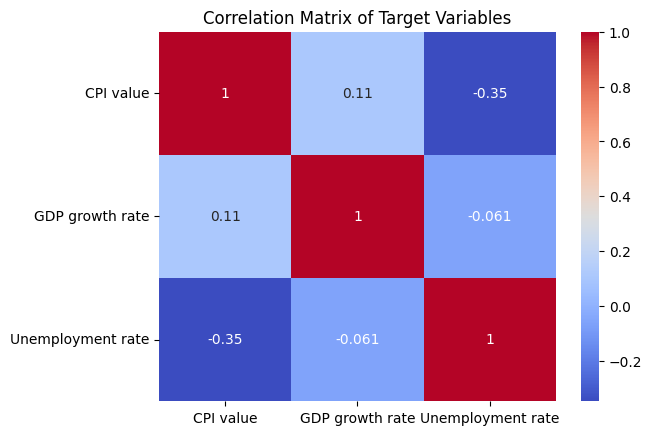

In [18]:
corr = train_data[target_columns].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Target Variables")
plt.show()

In [19]:
for col in target_columns:
    feature_corr = train_data.corr()[col].sort_values(ascending=False)
    print(f"Correlation of Features with {col}:\n", feature_corr)

Correlation of Features with CPI value:
 CPI value            1.000000
High_^GSPTSE         0.908032
Open_^GSPTSE         0.905835
Adj Close_^GSPTSE    0.905488
Close_^GSPTSE        0.905488
Low_^GSPTSE          0.903291
Volume_^GSPTSE       0.314884
GDP growth rate      0.108002
Unemployment rate   -0.347101
Name: CPI value, dtype: float64
Correlation of Features with GDP growth rate:
 GDP growth rate      1.000000
CPI value            0.108002
Adj Close_^GSPTSE    0.101321
Close_^GSPTSE        0.101321
High_^GSPTSE         0.101296
Low_^GSPTSE          0.101190
Open_^GSPTSE         0.101074
Volume_^GSPTSE       0.031246
Unemployment rate   -0.061118
Name: GDP growth rate, dtype: float64
Correlation of Features with Unemployment rate:
 Unemployment rate    1.000000
Volume_^GSPTSE       0.046018
GDP growth rate     -0.061118
High_^GSPTSE        -0.336298
Open_^GSPTSE        -0.337973
Adj Close_^GSPTSE   -0.338035
Close_^GSPTSE       -0.338035
Low_^GSPTSE         -0.340852
CPI value    

In [20]:
X_train = train_data.drop(columns=target_columns)
y_train = train_data[target_columns]

X_val = validation_data.drop(columns=target_columns)
y_val = validation_data[target_columns]

X_test = test_data.drop(columns=target_columns)
y_test = test_data[target_columns]

In [21]:
mae_results = {}
rmse_results = {}
r2_results = {}

for label in target_columns:
    print(f"Processing target: {label}")

    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train[label])

    lr_preds = lr_model.predict(X_val)

    lr_mae = mean_absolute_error(y_val[label], lr_preds)
    lr_rmse = mean_squared_error(y_val[label], lr_preds)  
    lr_r2 = r2_score(y_val[label], lr_preds)

    mae_results[label] = lr_mae
    rmse_results[label] = lr_rmse
    r2_results[label] = lr_r2

    print(f"{label} ::: MAE: {lr_mae:.4f}, RMSE: {lr_rmse:.4f}, R2: {lr_r2:.4f}")

print("\nOverall Results:")
print("MAE:", mae_results)
print("RMSE:", rmse_results)
print("R2:", r2_results)

Processing target: CPI value
CPI value ::: MAE: 0.3182, RMSE: 0.1531, R2: 0.8512
Processing target: GDP growth rate
GDP growth rate ::: MAE: 0.9314, RMSE: 0.9870, R2: 0.0098
Processing target: Unemployment rate
Unemployment rate ::: MAE: 0.6668, RMSE: 0.8537, R2: 0.1381

Overall Results:
MAE: {'CPI value': np.float64(0.31815503434802384), 'GDP growth rate': np.float64(0.9313970060569564), 'Unemployment rate': np.float64(0.6667517052436629)}
RMSE: {'CPI value': np.float64(0.1531102072213941), 'GDP growth rate': np.float64(0.9870265364593326), 'Unemployment rate': np.float64(0.853748325361543)}
R2: {'CPI value': 0.8511808193356272, 'GDP growth rate': 0.009751573086235865, 'Unemployment rate': 0.1380983186781315}


In [22]:

mae_results = {}
rmse_results = {}
r2_results = {}

for label in target_columns:
    print(f"Processing target: {label}")
    

    svr_model = SVR()
    svr_model.fit(X_train, y_train[label])

    svr_preds = svr_model.predict(X_val)

    svr_mae = mean_absolute_error(y_val[label], svr_preds)
    svr_rmse = mean_squared_error(y_val[label], svr_preds) 
    svr_r2 = r2_score(y_val[label], svr_preds)

    mae_results[label] = svr_mae
    rmse_results[label] = svr_rmse
    r2_results[label] = svr_r2

    print(f"{label} ::: MAE: {svr_mae:.4f}, RMSE: {svr_rmse:.4f}, R2: {svr_r2:.4f}")

print("\nOverall Results for SVR:")
print("MAE:", mae_results)
print("RMSE:", rmse_results)
print("R2:", r2_results)

Processing target: CPI value
CPI value ::: MAE: 0.3057, RMSE: 0.1672, R2: 0.8375
Processing target: GDP growth rate
GDP growth rate ::: MAE: 0.7325, RMSE: 1.3591, R2: -0.3636
Processing target: Unemployment rate
Unemployment rate ::: MAE: 0.6105, RMSE: 1.1391, R2: -0.1500

Overall Results for SVR:
MAE: {'CPI value': np.float64(0.3056664362475984), 'GDP growth rate': np.float64(0.7325145925595195), 'Unemployment rate': np.float64(0.6104770509582035)}
RMSE: {'CPI value': np.float64(0.16717296967123613), 'GDP growth rate': np.float64(1.3591449305542196), 'Unemployment rate': np.float64(1.139103065606274)}
R2: {'CPI value': 0.8375121761821565, 'GDP growth rate': -0.3635815043606849, 'Unemployment rate': -0.14998157920740218}


In [23]:
mae_results = {}
rmse_results = {}
r2_results = {}

for label in target_columns:
    print(f"Processing target: {label}")

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train[label])

    rf_preds = rf_model.predict(X_val)

    rf_mae = mean_absolute_error(y_val[label], rf_preds)
    rf_rmse = mean_squared_error(y_val[label], rf_preds) 
    rf_r2 = r2_score(y_val[label], rf_preds)

    mae_results[label] = rf_mae
    rmse_results[label] = rf_rmse
    r2_results[label] = rf_r2

    print(f"{label} ::: MAE: {rf_mae:.4f}, RMSE: {rf_rmse:.4f}, R2: {rf_r2:.4f}")

print("\nOverall Results for Random Forest:")
print("MAE:", mae_results)
print("RMSE:", rmse_results)
print("R2:", r2_results)


Processing target: CPI value
CPI value ::: MAE: 0.0823, RMSE: 0.0204, R2: 0.9801
Processing target: GDP growth rate
GDP growth rate ::: MAE: 1.2378, RMSE: 1.8958, R2: -0.9020
Processing target: Unemployment rate
Unemployment rate ::: MAE: 0.1529, RMSE: 0.0940, R2: 0.9051

Overall Results for Random Forest:
MAE: {'CPI value': np.float64(0.08228915090852482), 'GDP growth rate': np.float64(1.237837198785349), 'Unemployment rate': np.float64(0.15288558349501902)}
RMSE: {'CPI value': np.float64(0.020443266094158422), 'GDP growth rate': np.float64(1.89579130895371), 'Unemployment rate': np.float64(0.09396050611483132)}
R2: {'CPI value': 0.9801296715258361, 'GDP growth rate': -0.9019796247651806, 'Unemployment rate': 0.9051421645085727}


In [24]:
# X = merged_data.drop(columns=target_columns)  # Drop the target column to get the features
# y = merged_data['CPI value']  # Target variable (dependent)
# lr_cv = cross_val_score(lr_model, X, y, cv=5, scoring='neg_mean_absolute_error')
# svr_cv = cross_val_score(svr_model, X, y, cv=5, scoring='neg_mean_absolute_error')
# rf_cv = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_absolute_error')

# print(f"Linear Regression ::: CV MAE: {-lr_cv.mean()}")
# print(f"SVR ::: CV MAE: {-svr_cv.mean()}")
# print(f"Random Forest ::: CV MAE: {-rf_cv.mean()}")